In [82]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
import matplotlib.pyplot as plt
import numpy as np
from LSsurf import smooth_xytb_fit
import pointCollection as pc
import sparseqr
import glob
import h5py
import os
import LSsurf
%matplotlib inline

In [84]:
data_top='/home/besmith4/shared/ATL11_processing/Arctic_003_cycle_03_07/U07'
all_files = ( os.path.join(basedir, filename) for basedir, dirs, files in os.walk(data_top) for filename in files   )
sorted_files = sorted(all_files, key = os.path.getsize, reverse=True)

<class 'pointCollection.ATL11.data.data'> with shape (37022, 5),
with fields:
['latitude', 'longitude', 'h_corr', 'h_corr_sigma', 'h_corr_sigma_systematic', 'delta_time', 'quality_summary', 'ref_pt', 'dem_h', 'x_atc', 'cycle_number', 'ref_surf_quality', 'x', 'y']

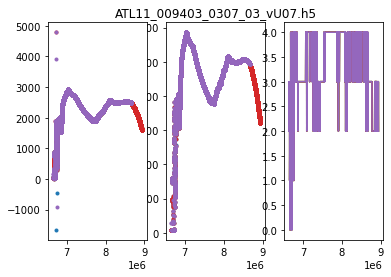

In [85]:
for file in sorted_files[0:1]:
    try:
        D11=pc.ATL11.data().from_h5(file)
        with h5py.File(file,'r') as h5f:
            qs=np.array(h5f['/pt2/ref_surf/quality_summary'])
        D11.assign({'ref_surf_quality':qs})
        D11.get_xy(EPSG=3413)
    except Exception: 
        continue
    plt.figure(1, figsize=[6, 4]); plt.clf()
    plt.subplot(132)
    plt.plot(D11.x_atc[qs<6], D11.h_corr[qs<6,:],'.')
    plt.title(os.path.basename(file))
    plt.subplot(131)
    plt.plot(D11.x_atc, D11.h_corr,'.')
    plt.subplot(133)
    plt.plot(D11.x_atc, np.sum(np.isfinite(D11.h_corr), axis=1))
D11.index(D11.ref_surf_quality < 6)
   

In [86]:

# define the domain's width in x, y, and time
W={'x':8.e4,'y':200,'t':.2}
# define the grid center:
XR=np.nanmean(D11.x_atc)+np.array([-1, 1])*W['x']/2
ctr={'x':XR[0]+W['x']/2., 'y':0., 't':0.}
# define the grid spacing
spacing={'z0':100, 'dz':100, 'dt':.1}


In [87]:
D=pc.data().from_dict({'x':D11.x_atc[:,0], 'y':np.zeros_like(D11.x_atc[:,0]),'z':D11.h_corr[:,0],\
                       'time':np.zeros_like(D11.x_atc[:,0]), 'sigma':D11.h_corr_sigma[:,0]})
# To ensure a time-constant simulation, replicate the data at times -0.5 and 0.5:
#data=pc.data().from_list([D, D.copy().assign({'time':np.zeros_like(D.x)}), D.copy().assign({'time':np.zeros_like(D.x)+0.5})])
data=D
data.index(np.isfinite(data.z) & np.isfinite(data.sigma) & (data.sigma>0))


<class 'pointCollection.data.data'> with shape (34146,),
with fields:
['x', 'y', 'z', 'time', 'sigma']

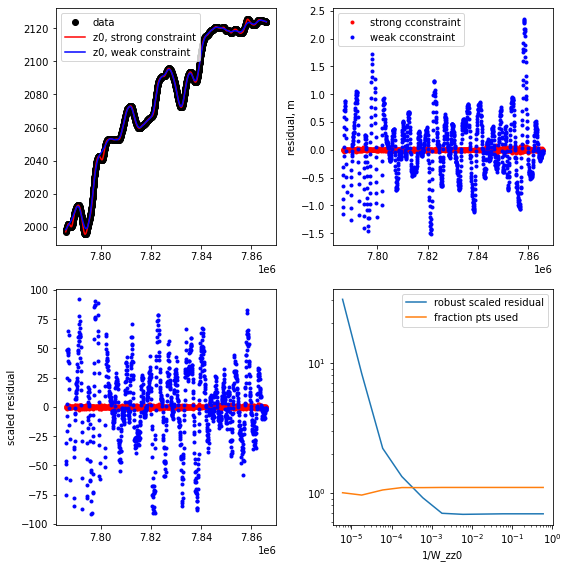

In [103]:
# define the expected statistics of the surface
from LSsurf import smooth_xytb_fit
E_d3zdx2dt=0.0001
E_d2z0dx2=0.006
E_d2zdt2=5000

data_gap_scale=2500

data1=data[(data.x > XR[0]) & (data.x < XR[0]+W['x'])]

scale_vals=np.array([ 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 10, 100])[::-1]
sigma_hat_vals=np.zeros_like(scale_vals)
sigma_hat_s_vals=np.zeros_like(scale_vals)
N_vals=np.zeros_like(scale_vals)
S=[]
d_ed=[]
for ii, scale_val in enumerate(scale_vals):
    # run the fit
    E_RMS={'d2z0_dx2': E_d2z0dx2*scale_val,
     'dz0_dx': E_d2z0dx2*data_gap_scale*scale_val,
     'd3z_dx2dt':E_d3zdx2dt ,
     'd2z_dxdt': E_d3zdx2dt*data_gap_scale,
     'd2z_dt2': E_d2zdt2}
    
    S.append(smooth_xytb_fit(data=data1, ctr=ctr, W=W, spacing=spacing, E_RMS=E_RMS,
                     reference_epoch=1, N_subset=None, compute_E=False,
                     max_iterations=5,
                     VERBOSE=False, dzdt_lags=[1]))
    d_ed.append(S[-1]['data'])
    d_ed[-1].index(d_ed[-1].three_sigma_edit==1)
    sigma_hat_vals[ii] = LSsurf.RDE(d_ed[-1].z-d_ed[-1].z_est)
    N_vals[ii]=d_ed[-1].size
    sigma_hat_s_vals[ii] = LSsurf.RDE((d_ed[-1].z-d_ed[-1].z_est)/d_ed[-1].sigma)
    
# plot the results
fig=plt.figure(3, figsize=[8,8])
fig.clf()
ax=fig.add_subplot(221)
ax.plot(data1.x, data1.z,'ko', label='data')
ax.plot(S[0]['m']['z0'].x, S[0]['m']['z0'].z0[0,:],'r', label='z0, strong constraint')
ax.plot(S[-1]['m']['z0'].x, S[-1]['m']['z0'].z0[0,:],'b', label='z0, weak constraint')

plt.legend();
ax=[ax, fig.add_subplot(222, sharex=ax)]

ax[-1].plot(d_ed[0].x, (d_ed[0].z-d_ed[0].z_est),'r.', label='strong cconstraint')
ax[-1].plot(d_ed[-1].x, (d_ed[-1].z-d_ed[-1].z_est),'b.', label='weak cconstraint')
ax[-1].set_ylabel('residual, m')
ax[-1].legend()
ax.append(fig.add_subplot(223, sharex=ax[0]))

ax[-1].plot(d_ed[0].x, (d_ed[0].z-d_ed[0].z_est)/d_ed[0].sigma,'r.', label='strong cconstraint')
ax[-1].plot(d_ed[-1].x, (d_ed[-1].z-d_ed[-1].z_est)/d_ed[-1].sigma,'b.', label='weak constraint')
ax[-1].set_ylabel('scaled residual')

ax=[ax, fig.add_subplot(224)]

ax[-1].loglog(scale_vals*E_d2z0dx2, sigma_hat_s_vals, label='robust scaled residual')
ax[-1].loglog(scale_vals*E_d2z0dx2, N_vals/S[-1]['data'].size, label='fraction pts used')
ax[-1].legend()
ax[-1].set_xlabel('1/W_zz0')

fig.tight_layout()

In [74]:
def safe_interp(x, x0_in, y0_in):
    y=np.NaN
    
    if x0_in[-1] < x0_in[0]:
        x0=x0_in[::-1]
        y0=y0_in[::-1]
    else:
        x0=x0_in
        y0=y0_in
    try:
        i0=np.argwhere(x0 < x)[-1][0]
        i1=np.argwhere(x0 >=x)[0][0]
        #print([i0, i1])
        #print( x0[[i0, i1]])
        #print( y0[[i0, i1]])
        y=np.interp(x, x0[[i0, i1]], y0[[i0, i1]])
    except Exception:
        pass
    return y


In [75]:
def read_ATL11_file(file, mask_file):

    D11=pc.ATL11.data().from_h5(file)
    with h5py.File(file,'r') as h5f:
        qs=np.array(h5f['/pt2/ref_surf/quality_summary'])
    D11.assign({'ref_surf_quality':qs})
    D11.get_xy(EPSG=3413)
    XR=np.array([np.nanmin(D11.x), np.nanmax(D11.x)])
    YR=np.array([np.nanmin(D11.y), np.nanmax(D11.y)])
    mask=pc.grid.data().from_geotif(mask_file, bounds=[XR, YR]).interp(D11.x[:,0], D11.y[:,0]) > 0.5
    D11.index(mask & (D11.ref_surf_quality <1))
    return D11

In [76]:
def find_best_wxx0(D11):

    scale_vals=np.array([ 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300])

    E_d3zdx2dt=0.0001
    E_d2z0dx2=0.006
    E_d2zdt2=5000

    data_gap_scale=2500

    # define the domain's width in x, y, and time
    W={'x':4.e4,'y':200,'t':.2}
    # define the grid center:
    XR=np.nanmean(D11.x_atc)+np.array([-1, 1])*W['x']/2
    ctr={'x':XR[0]+W['x']/2., 'y':0., 't':0.}
    # define the grid spacing
    spacing={'z0':100, 'dz':100, 'dt':.1}

    dN=np.ceil(W['x']/30).astype(int)

    L_interp={}

    for pt0 in np.arange(D11.ref_pt[0,0]+dN/2, D11.ref_pt[-1,0], dN):
        ii=np.flatnonzero(np.abs(D11.ref_pt[:,0]-pt0)<3*dN/2)
        N_good=np.sum(np.isfinite(D11.h_corr[ii,:]), axis=0)
        if np.max(N_good)<0.9*dN:
            continue
        bc=np.argmax(N_good)
        nb=N_good[bc]

        xy_ctr=[np.nanmean(D11.x[ii, bc]), np.nanmean(D11.y[ii, bc]), np.nanmean(D11.h_corr[ii, bc])]

        D=pc.data().from_dict({'x':D11.x_atc[ii,bc], 'y':np.zeros_like(ii, dtype=float),'z':D11.h_corr[ii,bc],\
                           'time':np.zeros_like(ii, dtype=float), 'sigma':D11.h_corr_sigma[ii,bc]})
        D.index(np.isfinite(D.z) & np.isfinite(D.sigma) & (D.sigma>0))
        S=[]
        ctr={'x':np.nanmean(D.x), 'y':0., 't':0.}

        L_curve={key:[] for key in ['wzz0', 'sigma_hat_s', 'N']}

        for  scale_val in scale_vals:
            # run the fit
            E_RMS={'d2z0_dx2': E_d2z0dx2*scale_val,
             'dz0_dx': E_d2z0dx2*data_gap_scale*scale_val,
             'd3z_dx2dt':E_d3zdx2dt ,
             'd2z_dxdt': E_d3zdx2dt*data_gap_scale,
             'd2z_dt2': E_d2zdt2}
            S.append(smooth_xytb_fit(data=D, ctr=ctr, W=W, spacing=spacing, E_RMS=E_RMS,
                         reference_epoch=1, N_subset=None, compute_E=False,
                         max_iterations=5,
                         VERBOSE=False, dzdt_lags=[1]))
            d_ed = S[-1]['data']
            d_ed.index(d_ed.three_sigma_edit==1)

            L_curve['sigma_hat_s'].append( LSsurf.RDE((d_ed.z-d_ed.z_est)/d_ed.sigma))
            L_curve['wzz0'].append(E_RMS['d2z0_dx2'])
            L_curve['N'].append(d_ed.size)
        for key in L_curve.keys():
            L_curve[key] = np.array(L_curve[key])

        L_interp[pt0] = {"w_for_r_of_1":safe_interp(1, L_curve['sigma_hat_s'], L_curve['wzz0']), 
                        'w_for_r_10pct_above_min':safe_interp(1.1*L_curve['sigma_hat_s'].min(), L_curve['sigma_hat_s'], L_curve['wzz0']), 
                        'x': xy_ctr[0], 
                        'y': xy_ctr[1],
                        'z': xy_ctr[2]}
    return L_interp

In [77]:

D11=read_ATL11_file(sorted_files[10],'/home/besmith4/nobackup/masks/GimpIceMask_100m_edited.tif' )
L_interp=find_best_wxx0(D11)

fig=plt.figure(6); plt.clf()
h0=fig.add_subplot(211)
plt.plot(D11.ref_pt[:,0], D11.h_corr,'.')
fig.add_subplot(212, sharex=h0)
plt.plot(np.array(list(L_interp.keys())), np.log10(np.array([L_interp[key]['w_for_r_10_pct_above_min'] for key in L_interp.keys()])),'ks')
plt.plot(np.array(list(L_interp.keys())), np.log10(np.array([L_interp[key]['w_for_r_of_1'] for key in L_interp.keys()])),'r*')



NameError: name 'sorted_files' is not defined

In [28]:
import re
re_11=re.compile('\d\d_vU07.h5')

with open('/home/besmith4/temp/wxx_queue.txt','w') as fh:
    for file in sorted_files:
        if re_11.search(file) is None:
            continue
        out_file = '/home/besmith4/nobackup/ATL11_wxx_analysis/'+os.path.basename(file)
        fh.write(f'python3 ~/bin/best_wxx0_for_ATL11.py {file} {out_file}\n')


In [20]:
out_files=glob.glob('/home/besmith4/nobackup/ATL11_wxx_analysis/*.h5')
D_list=[]
for file in out_files:
    D_list.append(pc.data().from_h5(file, field_dict={None:['w_for_r_10pct_above_min','w_for_r_of_1', 'x','y','z' ]}))

w_for_r_10pct_above_min  Dataset {13/Inf}
w_for_r_of_1             Dataset {13/Inf}
x                        Dataset {13/Inf}
y                        Dataset {13/Inf}
z                        Dataset {13/Inf}

In [10]:
! h5ls /home/besmith4/nobackup/ATL11_wxx_analysis/ATL11_106305_0307_03_vU07.h5


/usr/local/bin/bash: h5ls: command not found


In [68]:
D_all=pc.data().from_list(D_list)
D_all.index(np.isfinite(D_all.w_for_r_of_1))

<class 'pointCollection.data.data'> with shape (10787,),
with fields:
['w_for_r_of_1', 'x', 'w_for_r_10pct_above_min', 'y', 'z']

(-595116.9025882615, 738527.4820811591, -3312954.0711458735, -681977.446271271)

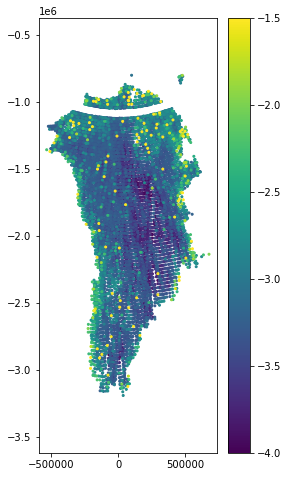

In [69]:
plt.figure(7, figsize=[4,8]);plt.clf()
ii=np.argsort(D_all.w_for_r_of_1)
plt.scatter(D_all.x[ii], D_all.y[ii], 4, c=np.log10(D_all.w_for_r_of_1[ii]), vmin=-4, vmax=-1.5); 
plt.colorbar(); plt.axis('equal')

In [70]:
x0=np.round((D_all.x+1j*D_all.y)/2.e4)*2.e4
ux0=np.unique(x0)
D_mb0=np.zeros_like(ux0)
for ii, xx0 in enumerate(ux0):
    D_mb0[ii]=np.nanmedian(D_all.w_for_r_of_1[x0==xx0])
    

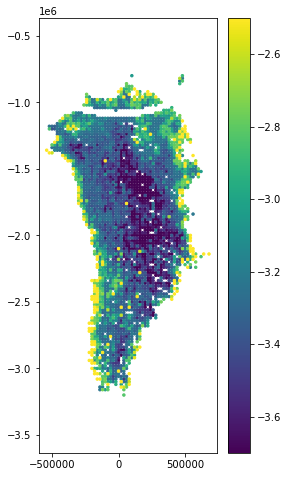

In [71]:
plt.figure(figsize=[4, 8]); plt.clf()
ii=np.argsort(D_mb0)
plt.scatter(np.real(ux0[ii]), np.imag(ux0[ii]), 6, c=np.log10(D_mb0[ii]), vmin=-3.7, vmax=-2.5)
plt.axis('equal'); plt.colorbar()

In [40]:
10**-2.5

0.0031622776601683794